## Summary

The dataset contains ~1,600 extracts (paragraphs or other snippets) from Terms of Service and Privacy Policy documents across popular web services. These have been curated by the ToS:DR project as being relevant and important to the end user, either for reasons good or bad, and segregated into topics, points (meaning), and good/bad/neutral status.

The end goal is to make these documents easier to digest/understand. This will be achieved by the following:
 - predicting topic based on word content
 - predicting whether terms are classified as good/bad/neutral, to potentially warn the user of any negative terms contained within.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('revised_points.csv', header = 'infer')

In [3]:
#select useful rows only
df = df[['id', 'needModeration','services', 'Source', 'quoteText', 'topics', 'case', 'point', 'score']]

In [4]:
data = df

In [5]:
data.topics.value_counts()

Personal Data                      194
Changes to Terms                   186
Governance                         171
Anonymity and Tracking             146
Suspension and Censorship          126
User information                   120
Ownership                           90
Scope of the copyright licence      87
Guarantee                           86
Right to leave the service          77
Cookies                             67
Third Parties                       65
Jurisdiction and governing laws     46
Content                             41
Waiving your right                  37
Law and government requests         36
Logs                                28
Business Transfers                  25
User choice                         25
Other                               17
Pricing                             12
Easy to read                         6
Name: topics, dtype: int64

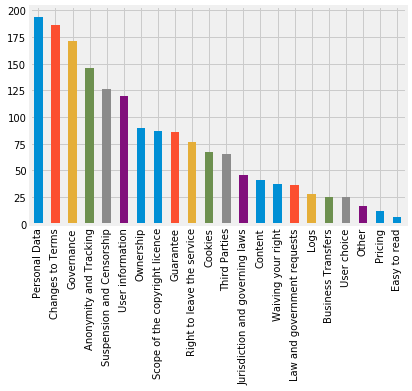

In [6]:
pd.value_counts(data['topics']).plot.bar();

In [7]:
#group small counts into 'Other', or drop accordingly

# data.topics.replace('Easy to read', 'Other', inplace=True)
# data.topics.replace('Pricing','Other', inplace=True)

In [8]:
#drop topics with low data counts
data = data[data.topics != 'Other']
data = data[data.topics != 'Pricing']
data = data[data.topics != 'Easy to read']

In [9]:
#clean the quote text
data['quoteText'] = data['quoteText'].str.replace(r"\n", " ")
data['quoteText'] = data['quoteText'].str.replace(r"\t", " ")
data['quoteText'] = data['quoteText'].str.replace(r"/", " ")
data['quoteText'] = data['quoteText'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
data['quoteText'] = data['quoteText'].str.replace(r"<strong>", " ")

In [10]:
data.quoteText.head()

0    We may automatically collect information using...
1    By registering for an account, you further agr...
2    We may suspend the Services or terminate the A...
3    You may only use a crawler to crawl this Web s...
4    you hereby do and shall grant to Automattic a ...
Name: quoteText, dtype: object

## Explore the dataset

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
cvec = CountVectorizer()
cvec.fit(data.quoteText)
len(cvec.get_feature_names())

4902

In [13]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(data.quoteText)
len(cvec.get_feature_names())

4649

In [14]:
# explore the top words in the quote text
cvec_mat = cvec.transform(data.quoteText)
words = cvec.get_feature_names()
a = cvec_mat.sum(axis=0)
word_df = pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False)
word_df.rename(columns={0: 'frequency'}, inplace=True)

In [15]:
word_df.head(10)

,frequency
information,1237
use,1075
services,788
content,638
service,625
terms,512
data,502
account,477
time,412
personal,395


There are similar words in the word database (eg. 'services' and 'service'. Lemmatization should fix this.

In [16]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['quoteText'].apply(tokenizer.tokenize)
# created a tokens column for future use

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# apply lemmatizer to each cell and return as string for use with Count Vectorizer and other methods
def lemmatize_block(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return " ".join(lemma_words)

data['lemmatized'] = data.tokens.apply(lemmatize_block)

In [17]:
data[['quoteText','tokens','lemmatized']].head()

,quoteText,tokens,lemmatized
0,We may automatically collect information using...,"[We, may, automatically, collect, information,...",we may automatically collect information using...
1,"By registering for an account, you further agr...","[By, registering, for, an, account, you, furth...",by registering for an account you further agre...
2,We may suspend the Services or terminate the A...,"[We, may, suspend, the, Services, or, terminat...",we may suspend the service or terminate the ag...
3,You may only use a crawler to crawl this Web s...,"[You, may, only, use, a, crawler, to, crawl, t...",you may only use a crawler to crawl this web s...
4,you hereby do and shall grant to Automattic a ...,"[you, hereby, do, and, shall, grant, to, Autom...",you hereby do and shall grant to automattic a ...


In [18]:
cvec_lem = CountVectorizer(stop_words = 'english')
cvec_lem.fit(data.lemmatized)
len(cvec_lem.get_feature_names())

4105

In [19]:
cvec_lem_mat = cvec_lem.transform(data.lemmatized)

In [20]:
lem_words = cvec_lem.get_feature_names()
a = cvec_lem_mat.sum(axis=0)
lem_word_df = pd.DataFrame(a,columns=lem_words).transpose().sort_values(by=0,ascending=False)
lem_word_df.rename(columns={0: 'frequency'}, inplace=True)

In [21]:
lem_word_df.head(10)

,frequency
service,1413
information,1237
use,1075
content,659
term,530
account,525
user,512
data,502
party,497
right,493


Lemmatization has enabled grouping of similar words. It is a relatively conservative approach but proved more useful than stemming (not shown here) in repeated analysis.

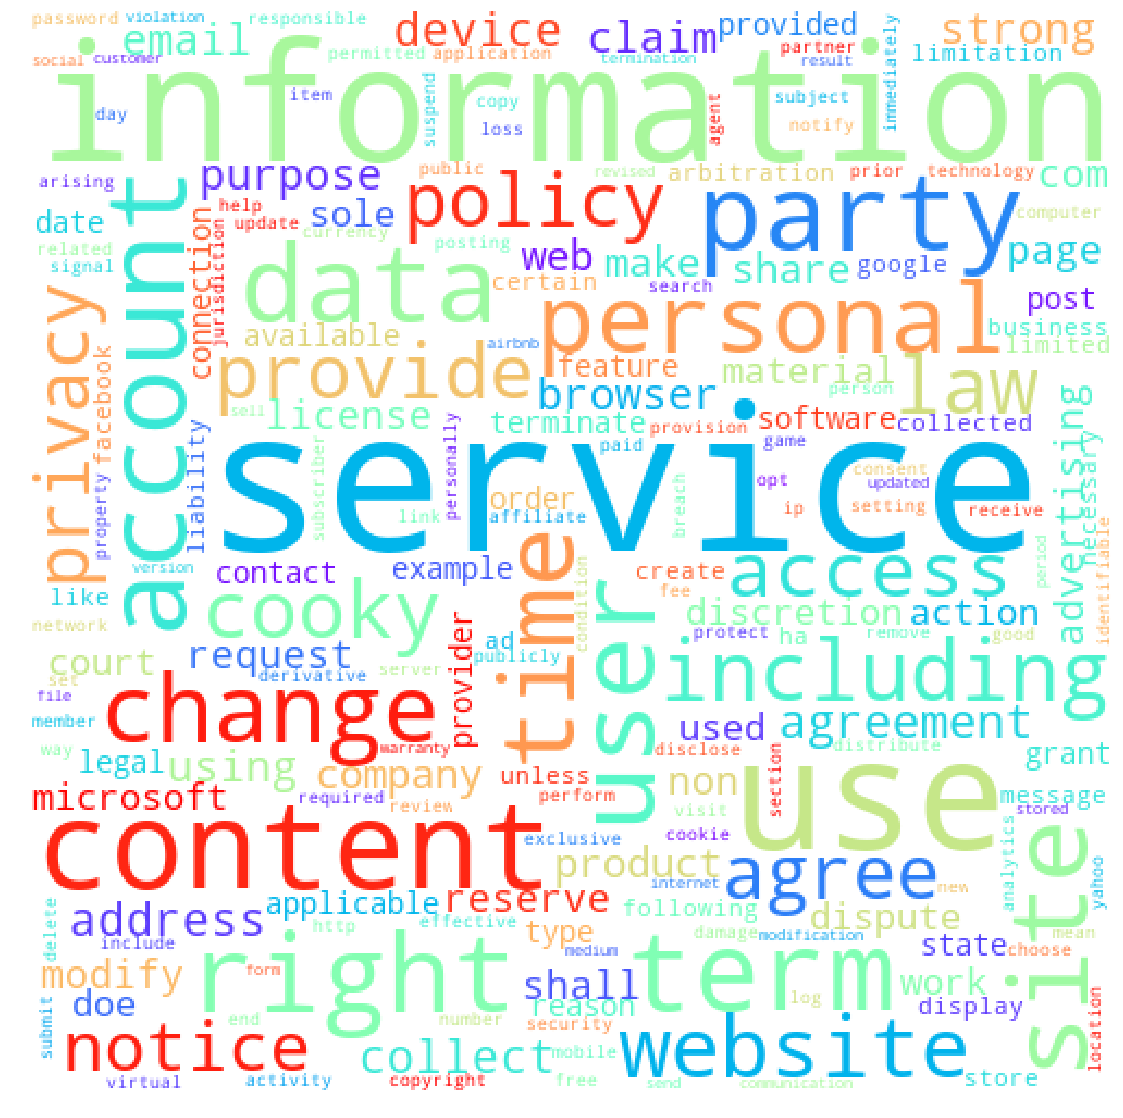

In [28]:
# visualize as a wordcloud
from wordcloud import WordCloud

wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2, width = 500, height = 500)

wc_gen = wc.generate_from_frequencies(dict(lem_word_df['frequency']))

plt.figure(figsize=(20,20))
plt.imshow(wc_gen)
plt.axis("off");

In [153]:
#the code below allows custom stopwords to be removed

from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['information','service','use','content','term',
                                            'right','time','party','change','account','user',
                                            'site','personal','data','website','collect','personal',
                                           'access','notice','including','policy','provide','privacy'])

Word Clouds can help visualize key words in documents, as seen above. However, Word Clouds by topic are difficult for obtaining meaning due to the large overlap between words in different topics, even with common stop words removed, as above.

This indicates that the documents/observations are largely similar, which means a model search should seek to identify less common words as predictors. TFIDF would be a good approach.

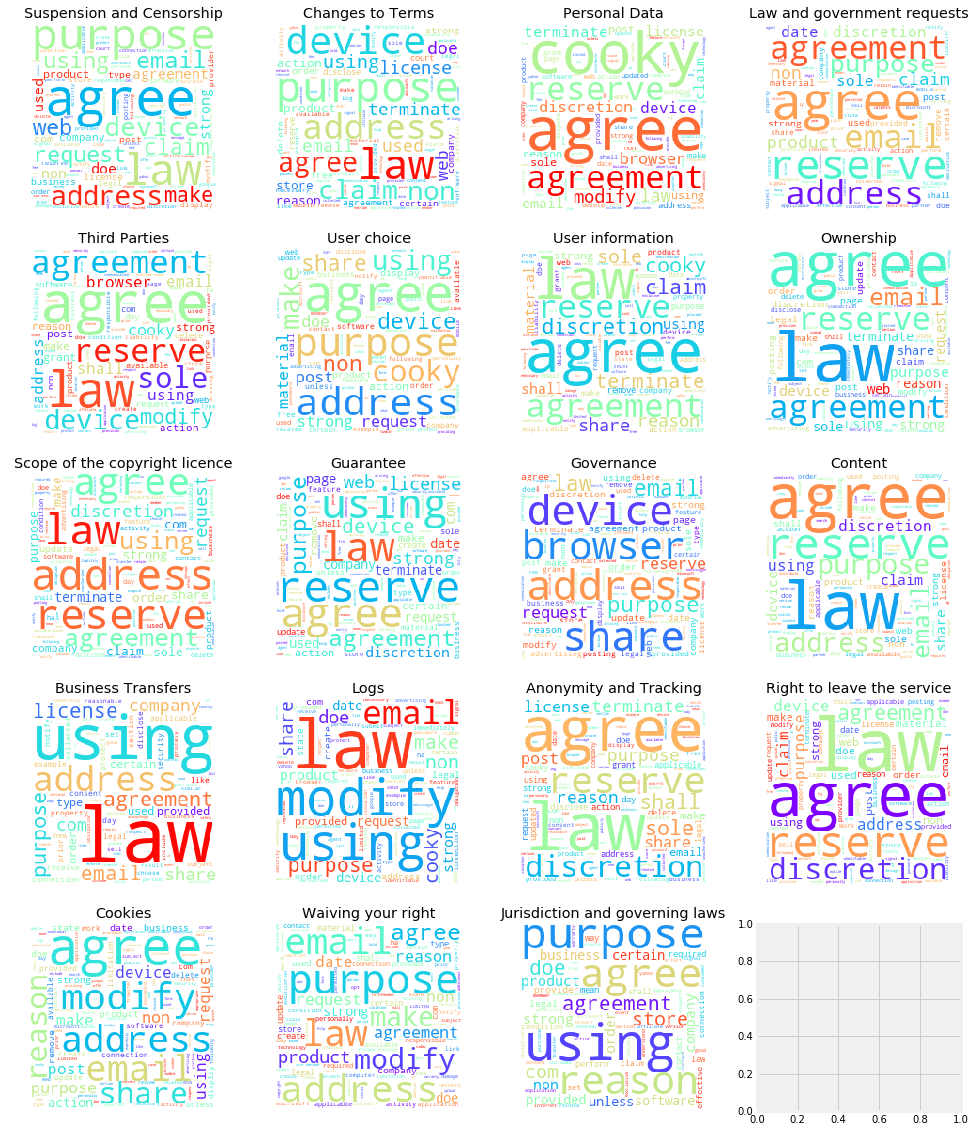

In [154]:
# word cloud for each topic (outcome variable)
topics = list(data.topics.unique())
wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2, width=200, height=200)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,20))
for ax, topic in zip(axs.flat, topics):
    subset = data[data.topics == topic]
    cvec_top = TfidfVectorizer(stop_words=stop_words)
    cvec_top.fit(subset.lemmatized)
    cvec_top_mat = cvec_top.transform(data.lemmatized)
    topic_words = cvec_top.get_feature_names()
    a = cvec_top_mat.sum(axis=0)
    top_word_df = pd.DataFrame(a,columns=topic_words).transpose().sort_values(by=0,ascending=False)
    wc_top = wc.generate_from_frequencies(dict(top_word_df[0]))
    ax.imshow(wc_top)
    ax.set_title(str(topic))
    ax.axis("off")

## Modelling

The train-test split below is used throughout.

In [155]:
X = data[['lemmatized']]
y = data['topics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [156]:
#verify y is stratified
y_test.value_counts()

Personal Data                      58
Changes to Terms                   56
Governance                         51
Anonymity and Tracking             44
Suspension and Censorship          38
User information                   36
Ownership                          27
Scope of the copyright licence     26
Guarantee                          26
Right to leave the service         23
Cookies                            20
Third Parties                      20
Jurisdiction and governing laws    14
Content                            12
Law and government requests        11
Waiving your right                 11
Logs                                8
User choice                         8
Business Transfers                  7
Name: topics, dtype: int64

In [157]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train['lemmatized'])
X_train_counts = cv.transform(X_train['lemmatized'])
X_test_counts = cv.transform(X_test['lemmatized'])

In [158]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr.fit(X_train_counts, y_train)

lr.score(X_train_counts, y_train)

0.9948141745894555

Due to the nature of the dataset, a high score is obtained on the train set: overfitting is common in NLP and difficult to address.

The initial test score is of greater importance:

In [159]:
lr.score(X_test_counts, y_test)

0.6149193548387096

In [160]:
# obtain predicted topics
y_train_preds = lr.predict(X_train_counts)
y_test_preds = lr.predict(X_test_counts)

In [161]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def scores(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = scores(y_test, y_test_preds)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.615, precision = 0.621, recall = 0.615, f1 = 0.614


These are promising scores compared to the baseline:

In [162]:
baseline = y_test.value_counts().max() / len(y_test)
print(baseline)

0.11693548387096774


In [163]:
from sklearn.metrics import confusion_matrix, classification_report

def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [164]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

The confusion matrices below show how the model performed at classifying test data into the 19 topics.

In [165]:
print(confusion_matrix(y_test, y_test_preds))

[[25  0  0  0  4  1  2  0  1  0  0  5  0  0  0  0  0  6  0]
 [ 0  5  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 52  0  0  2  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 1  0  0  1  0  1  0  0  0  0  3  2  0  0  0  0  0  4  0]
 [ 6  0  0  0 10  0  0  0  0  0  0  2  0  0  0  1  0  1  0]
 [ 1  0  1  0  0 30  3  1  0  1  2  4  1  2  4  0  0  0  1]
 [ 1  0  0  1  0  4 17  0  0  0  1  1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 12  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  8  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  2  0  0  0  0  0  2  0]
 [ 1  0  0  0  0  0  2  0  0  0 14  2  3  3  0  0  0  2  0]
 [ 5  0  0  1  0  3  0  0  4  3  1 32  0  0  1  3  0  5  0]
 [ 0  0  0  2  0  2  2  0  0  0  1  0 13  0  2  0  0  1  0]
 [ 0  0  0  0  0  3  0  0  0  0  2  0  1 19  0  0  0  1  0]
 [ 0  0  0  0  0  2  3  0  0  0  1  1  1  0 30  0  0  0  0]
 [ 2  0  0  1  1  0  0  0  0  0  1  7  0  0  0  7  0  1  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1

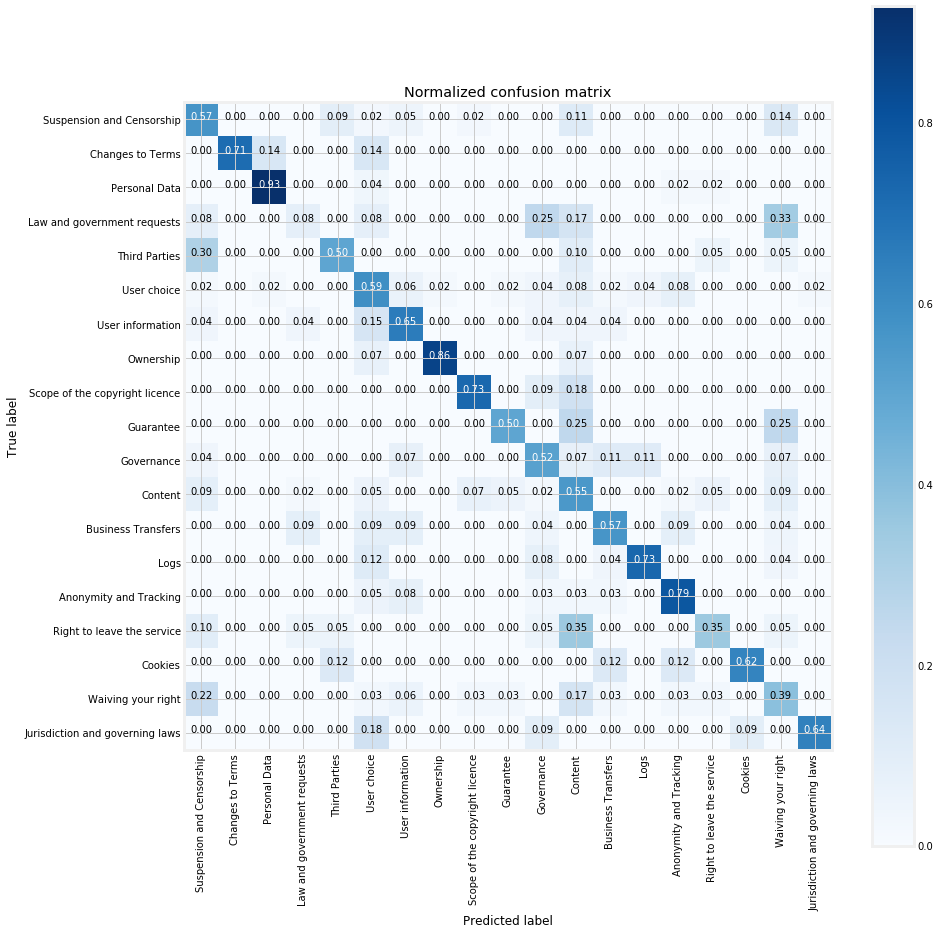

In [166]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(cnf_matrix, classes=topics, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The first model makes good overall predictions with some clear misses (eg. Law & gov't requests)

For potential improvement on the bag of words model, TFIDF should account better for common words across documents.

In [167]:
# try TFIDF as alternative
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train['lemmatized'])
X_train_tfidf = tfidf.transform(X_train['lemmatized'])
X_test_tfidf = tfidf.transform(X_test['lemmatized'])

In [168]:
lr_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf = lr_tfidf.predict(X_test_tfidf)

In [169]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.635, precision = 0.639, recall = 0.635, f1 = 0.633


TFIDF is a small but clear improvement on the Bag of Words(0.635 vs 0.615)

In [41]:
lr_tfidf = LogisticRegression(C=1, class_weight='balanced', solver='liblinear', 
                         multi_class='auto', random_state=40)
lr_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf = lr_tfidf.predict(X_test_tfidf)

In [42]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.643, precision = 0.643, recall = 0.643, f1 = 0.636


Our dataset has some imbalance issues, so this can be addressed by oversampling.

In [170]:
from imblearn.over_sampling import RandomOverSampler

In [171]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X_train_tfidf, y_train)

print(pd.Series(y_resampled).value_counts())

Logs                               136
User information                   136
Jurisdiction and governing laws    136
Governance                         136
Guarantee                          136
Personal Data                      136
Cookies                            136
Ownership                          136
Right to leave the service         136
Law and government requests        136
Changes to Terms                   136
Content                            136
User choice                        136
Scope of the copyright licence     136
Third Parties                      136
Waiving your right                 136
Suspension and Censorship          136
Business Transfers                 136
Anonymity and Tracking             136
dtype: int64


In [172]:
lr_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=7)
lr_tfidf.fit(X_resampled, y_resampled)

y_preds_oversampled = lr_tfidf.predict(X_test_tfidf)

In [173]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.644, recall = 0.641, f1 = 0.638


Resampling resulted in a very minor improvement in scores

Refine Logistic Regression model further using GridSearch

In [174]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [175]:
def fitter(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print(model.score(X_train, y_train))
    print(model.score(X_test, y_test))
    print()
    print(classification_report(y_train, model.predict(X_train)))
    print()
    print(classification_report(y_test, model.predict(X_test)))

In [176]:
lr_tfidf_gs = LogisticRegression()
model_params = {'penalty':['l2'],
             'C':np.logspace(-2,2,5),
             'class_weight':['balanced',None],
             'solver':['newton-cg','lbfgs'],
             'multi_class':['multinomial'],
             'max_iter':[1000]
            }
gs = GridSearchCV(lr_tfidf_gs, model_params, cv=5, iid=False)    
fitter(gs, X_resampled, y_resampled, X_test_tfidf, y_test)

0.9953560371517027
0.6411290322580645

[[134   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0 136   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 136   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0 136   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0 136   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0 136   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0 136   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 134   0   2   0   0   0   0   0
    0]
 [  2   0   0   0   0   0   0   0   0   0   0 133   0   0   0   0   0 

In [177]:
gs.best_params_

{'C': 100.0,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [47]:
gs.best_score_

0.6406725947496648

In [344]:
lr_tfidf = LogisticRegression(C=100.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial',
                          random_state=7)
lr_tfidf.fit(X_resampled, y_resampled)

y_preds_oversampled = lr_tfidf.predict(X_test_tfidf)

In [345]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.642, recall = 0.641, f1 = 0.638


This is the best-performing model obtained: GridSearch did not identify considerably better hyperparameters. Its performance is highly variable by topic as seen in the confusion matrix below, which likely is an indicator of the quality and differentiation of the topics. Some still perform poorly despite the tuning.

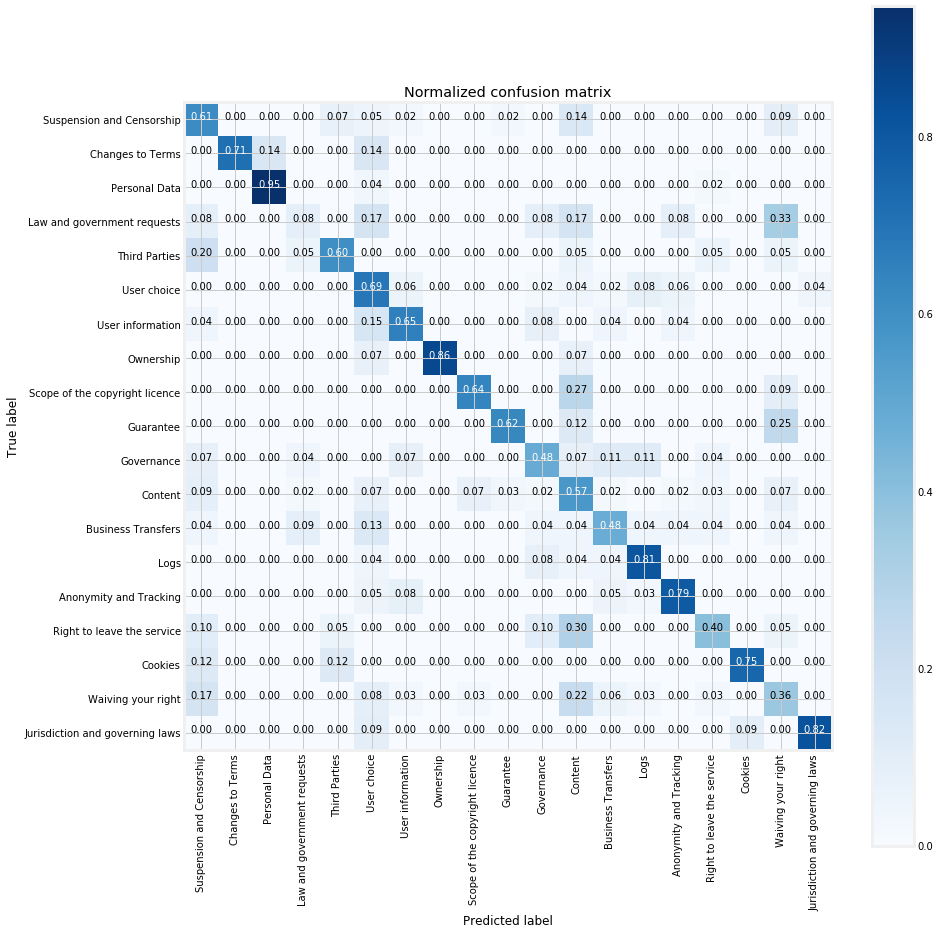

In [346]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_oversampled)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(cnf_matrix, classes=topics, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [347]:
# save the incorrect predictions for review later
conf_dict1 = {}
conf_dict1['true_topic'] = y_test
conf_dict1['pred_topic'] = y_preds_tfidf

## Beyond Logistic Regression
To compare, additional classification models are tested for their performance. Any showing comparable scores to logistic regression were further tuned using GridSearch (not shown here in full) and their best parameters inserted into the models below.

In [348]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid

In [349]:
models = [LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=7),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          SVC(gamma='auto'),
          RandomForestClassifier(n_estimators=100,
                                max_depth=1000,
                                class_weight='balanced'),
          ExtraTreesClassifier(n_estimators=100),
          MLPClassifier(solver='lbfgs', 
                    alpha=10**(-1), 
                    activation='identity', 
                    random_state=1,
                    batch_size='auto',
                       ),
          RidgeClassifier(alpha= 1.0,
                         class_weight= 'balanced',
                         normalize= True,
                         solver= 'sag',
                        tol=1e-2),
          Perceptron(max_iter=1000,tol=1e-3),
          PassiveAggressiveClassifier(max_iter=1000,tol=1e-3,
                                     C=10, class_weight='balanced',
                                     loss='squared_hinge'),
          SGDClassifier(alpha=.0001, loss='log',
                                       penalty="l2",
                                       max_iter=1000,
                                       tol=1e-3),
          MultinomialNB(alpha=.01, fit_prior=False),
          BernoulliNB(alpha=.01),
          LinearSVC(penalty="l2", C=0.1)]

In [58]:
model_dict = {}
for model in models:
    model.fit(X_resampled, y_resampled)
    y_preds_oversampled = model.predict(X_test_tfidf)
    accuracy, precision, recall, f1 = scores(y_test, y_preds_oversampled)
    model_dict[str(model).split('(')[0]] = [accuracy, precision, recall, f1]
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=7, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.641, precision = 0.644, recall = 0.641, f1 = 0.638

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
accuracy = 0.550, precision = 0.588, recall = 0.550, f1 = 0.547

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.458, precision = 0.466, recall = 0.458, f1 = 0.455



In [350]:
importances_sum = pd.DataFrame.from_dict(model_dict)
model_compare = importances_sum.T
model_compare.set_axis(['accuracy','precision','recall','f1'], axis=1, inplace=True)
model_compare = model_compare.sort_values('accuracy', ascending=False)

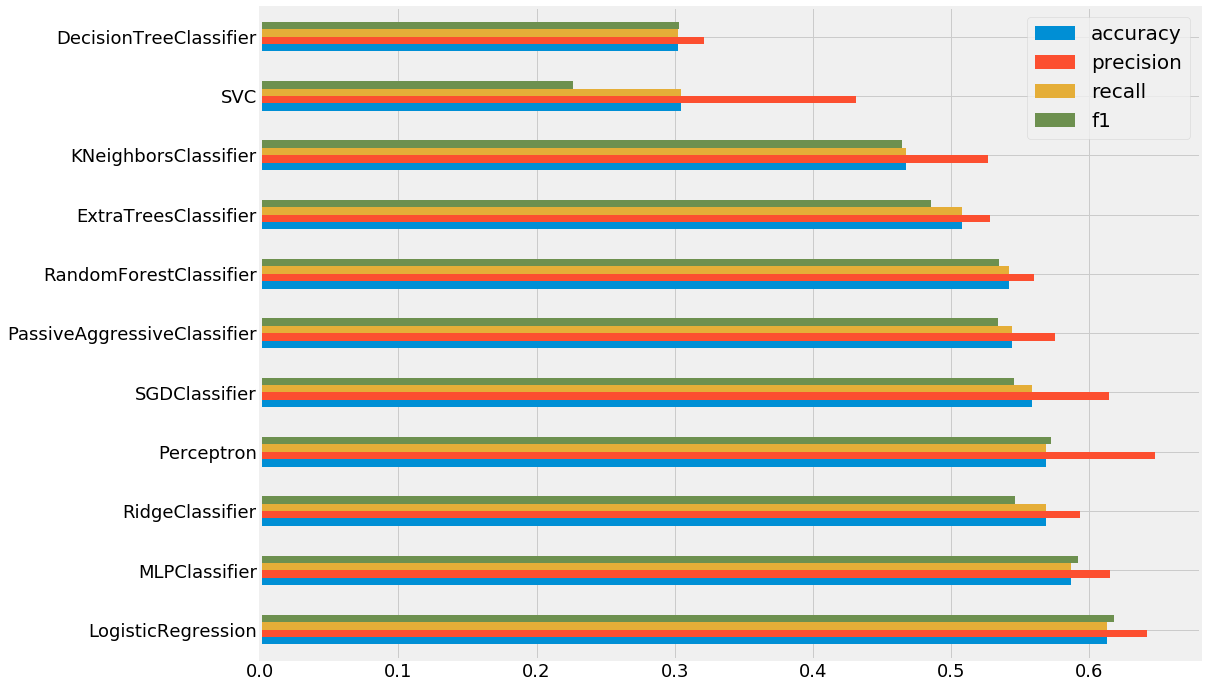

In [351]:
fig, ax = plt.subplots(figsize=(15, 12))
model_compare.plot(kind='barh', ax=ax, fontsize=18)
plt.legend(fontsize=20)
plt.show()

It can be seen above that Logistic Regression is slightly outperformed by two other classification models

## Alternative Models

Word2Vec / WordNet can potentially classify more intelligently than basic lemmatization/stemming.

In [64]:
import gensim

word2vec_path = "part-03/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [65]:
def  get_average_word2vec (tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [66]:
list_labels = list(y)

In [192]:
embeddings  = get_word2vec_embeddings(word2vec, data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.3, random_state=7)

In [193]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [194]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = scores(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.609, precision = 0.641, recall = 0.609, f1 = 0.615


In [196]:
sampler = RandomOverSampler(random_state=1)
X_resampled_w2v, y_resampled_w2v = sampler.fit_sample(X_train_word2vec, y_train_word2vec)

In [197]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_resampled_w2v, y_resampled_w2v)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = scores(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.613, precision = 0.642, recall = 0.613, f1 = 0.618


In [202]:
w2v_gs = LogisticRegression()
model_params = {'penalty':['l2'],
             'C':np.logspace(-2,2,5),
             'class_weight':['balanced',None],
             'solver':['newton-cg','lbfgs'],
             'multi_class':['multinomial'],
             'max_iter':[1000]
            }
gs = GridSearchCV(w2v_gs, model_params, cv=5, iid=False)    
fitter(gs, X_resampled_w2v, y_resampled_w2v, X_test_word2vec, y_test_word2vec)

0.9858886346300534
0.6169354838709677

[[134   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0 138   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0 133   1   0   0   0   0   2   0   0   1   0   0   1
    0]
 [  0   0   0   0   0   0 138   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0 138   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0 138   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0 138   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 134   2   0   2   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   1   1   0 125   1   0   0   5   0 

Unfortunately, on this occasion, Word2Vec performs slightly more poorly than earlier models, despite the relatively high precision.

## Principle Component Analysis

In [70]:
from  sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

lsa = TruncatedSVD(n_components=10)
lsa.fit(X_train_counts, y_train)
lsa_scores = lsa.transform(X_test_counts)

In [71]:
for i, pc in enumerate(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']):
    print(pc, 'weighting vector:\n', lsa.components_[i])
    print('-------------------------------------\n')

PC1 weighting vector:
 [8.36e-04 1.16e-03 1.13e-04 ... 4.67e-05 3.08e-04 1.90e-04]
-------------------------------------

PC2 weighting vector:
 [-2.13e-03 -8.92e-03 -2.28e-04 ...  4.60e-05 -2.31e-04  1.03e-04]
-------------------------------------

PC3 weighting vector:
 [ 2.54e-05  1.94e-02 -1.13e-04 ... -4.50e-05 -2.16e-04 -1.59e-04]
-------------------------------------

PC4 weighting vector:
 [-0.  0. -0. ...  0.  0.  0.]
-------------------------------------

PC5 weighting vector:
 [-1.10e-03 -3.68e-04 -1.59e-04 ...  1.13e-05  5.75e-05  1.59e-04]
-------------------------------------

PC6 weighting vector:
 [ 0. -0. -0. ... -0. -0. -0.]
-------------------------------------

PC7 weighting vector:
 [ 2.65e-03  3.77e-03 -5.36e-05 ...  4.94e-05 -2.68e-04 -1.97e-04]
-------------------------------------

PC8 weighting vector:
 [ 3.60e-04 -2.51e-03 -1.99e-04 ...  3.46e-05  2.65e-04 -2.41e-04]
-------------------------------------

PC9 weighting vector:
 [-1.40e-03  8.97e-04  3.27e-05 

In [72]:
exp_var_eigenvals = lsa.explained_variance_
exp_var_pct = lsa.explained_variance_ratio_

print('eigenvalues:\n', exp_var_eigenvals, '\n')
print('explained variance pct:\n', exp_var_pct)

eigenvalues:
 [8.37 3.56 2.98 2.66 1.7  1.68 1.51 1.47 1.21 1.17] 

explained variance pct:
 [0.12 0.05 0.04 0.04 0.02 0.02 0.02 0.02 0.02 0.02]


Explanatory value of PCA is relatively low for this dataset: difficult to condense to a small number of principle components.

## Unsupervised Learning

In [203]:
def lemmatize_block_keep_tokens(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return lemma_words

data['lemmatized_tokens'] = data.tokens.apply(lemmatize_block_keep_tokens)

In [204]:
dictionary = gensim.corpora.Dictionary(data['lemmatized_tokens'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 a
1 agreement
2 are
3 attendee
4 cause
5 harm
6 if
7 in
8 is
9 likely
10 manner


In [205]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data['lemmatized_tokens']]

In [206]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=19, id2word=dictionary, passes=2, workers=2)

In [207]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.054*"the" + 0.042*"to" + 0.029*"you" + 0.029*"we" + 0.026*"change" + 0.025*"of" + 0.019*"and" + 0.018*"use" + 0.017*"your" + 0.015*"policy"
Topic: 1 
Words: 0.067*"the" + 0.052*"or" + 0.037*"of" + 0.033*"to" + 0.032*"any" + 0.019*"a" + 0.018*"and" + 0.013*"service" + 0.011*"in" + 0.011*"for"
Topic: 2 
Words: 0.047*"of" + 0.042*"the" + 0.038*"to" + 0.036*"you" + 0.028*"any" + 0.028*"or" + 0.027*"and" + 0.018*"a" + 0.015*"your" + 0.014*"in"
Topic: 3 
Words: 0.037*"and" + 0.035*"to" + 0.028*"or" + 0.027*"we" + 0.024*"the" + 0.020*"you" + 0.019*"service" + 0.018*"of" + 0.017*"your" + 0.015*"may"
Topic: 4 
Words: 0.058*"or" + 0.037*"and" + 0.037*"the" + 0.033*"to" + 0.026*"of" + 0.025*"any" + 0.024*"you" + 0.018*"in" + 0.017*"that" + 0.013*"a"
Topic: 5 
Words: 0.042*"to" + 0.031*"and" + 0.027*"we" + 0.020*"a" + 0.018*"the" + 0.017*"of" + 0.015*"information" + 0.013*"our" + 0.013*"any" + 0.013*"it"
Topic: 6 
Words: 0.036*"to" + 0.033*"your" + 0.031*"and" + 0.026*"we" + 0.0

In [208]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [209]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=19, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"site" + 0.005*"term" + 0.004*"or" + 0.004*"service" + 0.004*"we" + 0.004*"a" + 0.004*"any" + 0.004*"the" + 0.004*"you" + 0.003*"access"
Topic: 1 Word: 0.004*"message" + 0.003*"or" + 0.003*"account" + 0.003*"we" + 0.003*"you" + 0.003*"in" + 0.003*"that" + 0.003*"a" + 0.003*"be" + 0.003*"arbitration"
Topic: 2 Word: 0.005*"or" + 0.005*"any" + 0.004*"be" + 0.004*"the" + 0.004*"service" + 0.004*"may" + 0.004*"and" + 0.004*"in" + 0.004*"you" + 0.004*"for"
Topic: 3 Word: 0.005*"or" + 0.005*"any" + 0.005*"of" + 0.005*"agreement" + 0.005*"claim" + 0.005*"time" + 0.004*"we" + 0.004*"this" + 0.004*"strong" + 0.004*"from"
Topic: 4 Word: 0.005*"we" + 0.004*"cooky" + 0.004*"information" + 0.004*"service" + 0.004*"any" + 0.004*"of" + 0.004*"site" + 0.004*"our" + 0.004*"on" + 0.004*"or"
Topic: 5 Word: 0.005*"content" + 0.004*"you" + 0.004*"for" + 0.004*"service" + 0.004*"virtual" + 0.004*"and" + 0.004*"our" + 0.003*"that" + 0.003*"we" + 0.003*"the"
Topic: 6 Word: 0.005*"last" + 0

In [80]:
lda_model_tfidf.get_topics()

array([[2.89e-03, 5.09e-04, 1.68e-03, ..., 7.44e-05, 7.44e-05, 7.44e-05],
       [3.12e-03, 5.48e-04, 2.20e-03, ..., 9.30e-05, 9.30e-05, 9.30e-05],
       [4.06e-03, 1.84e-03, 2.79e-03, ..., 6.45e-05, 6.45e-05, 6.45e-05],
       ...,
       [2.72e-03, 2.99e-03, 1.11e-03, ..., 8.71e-05, 8.71e-05, 8.71e-05],
       [2.04e-03, 1.83e-03, 1.82e-03, ..., 9.48e-05, 9.48e-05, 9.48e-05],
       [2.63e-03, 1.44e-03, 3.17e-03, ..., 3.15e-04, 3.15e-04, 6.70e-05]],
      dtype=float32)

In [246]:
lda_model_tfidf.

[(7,
  '0.006*"your" + 0.006*"account" + 0.005*"information" + 0.004*"you" + 0.004*"we" + 0.004*"content" + 0.004*"data" + 0.004*"any" + 0.004*"or" + 0.004*"user"'),
 (6,
  '0.005*"last" + 0.005*"we" + 0.005*"updated" + 0.005*"change" + 0.005*"our" + 0.004*"policy" + 0.004*"of" + 0.004*"or" + 0.004*"will" + 0.004*"on"'),
 (9,
  '0.005*"we" + 0.005*"change" + 0.004*"time" + 0.004*"not" + 0.004*"any" + 0.004*"or" + 0.004*"do" + 0.004*"term" + 0.004*"our" + 0.003*"policy"'),
 (15,
  '0.004*"at" + 0.004*"or" + 0.004*"term" + 0.004*"we" + 0.004*"information" + 0.004*"any" + 0.004*"is" + 0.004*"user" + 0.003*"service" + 0.003*"these"'),
 (0,
  '0.005*"site" + 0.005*"term" + 0.004*"or" + 0.004*"service" + 0.004*"we" + 0.004*"a" + 0.004*"any" + 0.004*"the" + 0.004*"you" + 0.003*"access"'),
 (12,
  '0.006*"information" + 0.005*"we" + 0.004*"you" + 0.004*"your" + 0.004*"will" + 0.004*"or" + 0.004*"it" + 0.004*"content" + 0.004*"service" + 0.004*"of"'),
 (3,
  '0.005*"or" + 0.005*"any" + 0.005*"o

In [254]:
list(lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability = 0.5))

[[(13, 0.80656284)],
 [(0, 0.59574205)],
 [(15, 0.79672414)],
 [(9, 0.82504827)],
 [(10, 0.8627372)],
 [],
 [(10, 0.8247324)],
 [(3, 0.8253041)],
 [(3, 0.6682111)],
 [],
 [(18, 0.78733736)],
 [(15, 0.6871502)],
 [(16, 0.8153424)],
 [(5, 0.8226769)],
 [(18, 0.8373289)],
 [(15, 0.8321081)],
 [(2, 0.77795607)],
 [(12, 0.79793745)],
 [(17, 0.7481306)],
 [(3, 0.78814167)],
 [(9, 0.742918)],
 [(4, 0.73747975)],
 [(8, 0.62392294)],
 [(7, 0.8018482)],
 [(4, 0.80128413)],
 [(6, 0.6887562)],
 [(14, 0.78694)],
 [(7, 0.77059376)],
 [(5, 0.70765406)],
 [(4, 0.8301556)],
 [(4, 0.8301556)],
 [(17, 0.8260073)],
 [(18, 0.7718293)],
 [(12, 0.7294768)],
 [(12, 0.73480326)],
 [(13, 0.77369636)],
 [(6, 0.747503)],
 [(17, 0.7108833)],
 [],
 [(17, 0.8130674)],
 [(9, 0.8141422)],
 [(17, 0.7942392)],
 [(5, 0.79869664)],
 [(11, 0.73390937)],
 [(12, 0.79232526)],
 [(13, 0.84357005)],
 [(16, 0.83597845)],
 [(10, 0.8219953)],
 [(12, 0.6858687)],
 [],
 [(6, 0.74894375)],
 [(6, 0.74894375)],
 [(8, 0.8232909)],
 [(14

In [258]:
unsup_topics = []
for i in (list(lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0.5))):
    if i == []:
        unsup_topics.append(None)
    else:
        for j in i:
            unsup_topics.append(j[0])

In [331]:
compare_class = pd.DataFrame(unsup_topics, columns=['unsup_class'])

In [332]:
compare_class['true'] = y

In [372]:
cf = pd.get_dummies(compare_class)

The plot below shows the association between unsupervised classes and the trained classes, to identify whether any groupings are made which correspond to known topics. Unsupervised topic #3 appears to have significant overlap with Personal Data, which is promising. However, Personal Data is a high-count category and so appears as the most prominent alignment in many unsupervised classes.



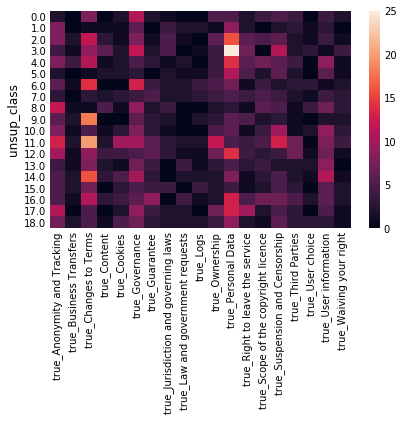

In [374]:
sns.heatmap(cf.groupby('unsup_class').sum())

In [377]:
compare_meaning = pd.DataFrame(unsup_topics, columns=['unsup_class'])
compare_meaning['true'] = data.case
cm = pd.get_dummies(compare_meaning)

In [ ]:
sns.heatmap(cf.groupby('unsup_class').sum())

## Good / Bad Classification

In [378]:
ratingdf = pd.read_csv('revised_points.csv', header = 'infer')

In [379]:
#select useful rows only
ratingdf = ratingdf[['id', 'needModeration','services', 'Source', 'quoteText', 'topics', 'case', 'point', 'score']]

In [380]:
ratingdf.point.isnull().sum()

133

In [381]:
ratingdf.dropna(subset=['point'], inplace=True)

In [382]:
ratingdf.point.value_counts()

bad        840
good       442
neutral    263
blocker      9
Good         1
Name: point, dtype: int64

In [383]:
ratingdf.point.replace('Bad', 'bad', inplace=True)
ratingdf.point.replace('blocker', 'bad', inplace=True)
ratingdf.point.replace('Good', 'good', inplace=True)

In [384]:
binarydf = ratingdf

In [385]:
#Use this option for binary bad/good
binarydf.point.replace('good', 'other', inplace=True)
binarydf.point.replace('neutral', 'other', inplace=True)
ratingdf = pd.get_dummies(binarydf, columns =['point'], drop_first=False)

In [386]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
ratingdf['tokens'] = ratingdf['quoteText'].apply(tokenizer.tokenize)
# created a tokens column for future use

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# apply lemmatizer to each cell and return as string for use with Count Vectorizer and other methods
def lemmatize_block(cell):
    lemma_words = []
    for word in cell:
        lemma_words.append(lemmatizer.lemmatize((word.lower())))
    return " ".join(lemma_words)

ratingdf['lemmatized'] = ratingdf.tokens.apply(lemmatize_block)

In [387]:
X = ratingdf[['lemmatized']]

#use for multiclass
#y = ratingdf['point']

#use for binary
y = ratingdf['point_other']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [388]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train['lemmatized'])
X_train_tfidf = tfidf.transform(X_train['lemmatized'])
X_test_tfidf = tfidf.transform(X_test['lemmatized'])

In [389]:
models = [LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=40),
          KNeighborsClassifier(leaf_size =10, weights='distance', metric='euclidean', n_neighbors=5),
          DecisionTreeClassifier(),
          SVC(gamma='auto'),
          RandomForestClassifier(n_estimators=100,
                                max_depth=1000,
                                class_weight='balanced'),
          ExtraTreesClassifier(n_estimators=100),
          MLPClassifier(solver='lbfgs', 
                    alpha=10**(-1),
                    hidden_layer_sizes=1, 
                    activation='identity', 
                    random_state=1,
                    batch_size='auto',
                       ),
          RidgeClassifier(alpha= 1.0,
                         class_weight= 'balanced',
                         normalize= True,
                         solver= 'sag',
                        tol=1e-2),
          Perceptron(max_iter=1000,tol=1e-3),
          PassiveAggressiveClassifier(max_iter=1000,tol=1e-3,
                                     C=10, class_weight='balanced',
                                     loss='squared_hinge'),
          SGDClassifier(alpha=.0001, loss='log',
                                       penalty="l2",
                                       max_iter=1000,
                                       tol=1e-3),
          MultinomialNB(alpha=.01, fit_prior=False),
          BernoulliNB(alpha=.01),
          LinearSVC(penalty="l2", C=0.1)]

In [390]:
for model in models:
    model.fit(X_train_tfidf, y_train)
    y_preds = model.predict(X_test_tfidf)
    accuracy, precision, recall, f1 = scores(y_test, y_preds)
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.737, precision = 0.738, recall = 0.737, f1 = 0.737

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
accuracy = 0.752, precision = 0.753, recall = 0.752, f1 = 0.749

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.657, precision = 0.658, recall = 0.657, f1 = 0.658



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
accuracy = 0.546, precision = 0.298, recall = 0.546, f1 = 0.386

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1000, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
accuracy = 0.754, precision = 0.754, recall = 0.754, f1 = 0.754

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
       

In [391]:
knn_tfidf_gs = KNeighborsClassifier()
model_params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,15,20],
             'weights':['uniform', 'distance'],
             'algorithm':['brute'],
             'leaf_size':[10,20,30,50,75,100],
             'metric':['euclidean','manhattan','minkowski']}
gs = GridSearchCV(knn_tfidf_gs, model_params, cv=5)    
fitter(gs, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.9981617647058824
0.7516059957173448

[[594   0]
 [  2 492]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       494

   micro avg       1.00      1.00      1.00      1088
   macro avg       1.00      1.00      1.00      1088
weighted avg       1.00      1.00      1.00      1088


[[211  44]
 [ 72 140]]

              precision    recall  f1-score   support

           0       0.75      0.83      0.78       255
           1       0.76      0.66      0.71       212

   micro avg       0.75      0.75      0.75       467
   macro avg       0.75      0.74      0.75       467
weighted avg       0.75      0.75      0.75       467



In [96]:
gs.best_params_

{'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'euclidean',
 'n_neighbors': 5,
 'weights': 'distance'}

In [97]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X_train_tfidf, y_train)

In [98]:
for model in models:
    model.fit(X_resampled, y_resampled)
    y_preds = model.predict(X_test_tfidf)
    accuracy, precision, recall, f1 = scores(y_test, y_preds)
    print(model)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    print()

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
accuracy = 0.741, precision = 0.742, recall = 0.741, f1 = 0.741

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
accuracy = 0.745, precision = 0.745, recall = 0.745, f1 = 0.745

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy = 0.625, precision = 0.627, recall = 0.625, f1 = 0.626

SV

In [99]:
knn_tfidf = KNeighborsClassifier(leaf_size =10, weights='distance', metric='euclidean', n_neighbors=5)
knn_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf = knn_tfidf.predict(X_test_tfidf)

In [100]:
accuracy, precision, recall, f1 = scores(y_test, y_preds_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.752, precision = 0.753, recall = 0.752, f1 = 0.749


In [101]:
conf_dict2= {}
conf_dict2['true_class'] = y_test
conf_dict2['pred_class'] = y_preds_tfidf

In [102]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

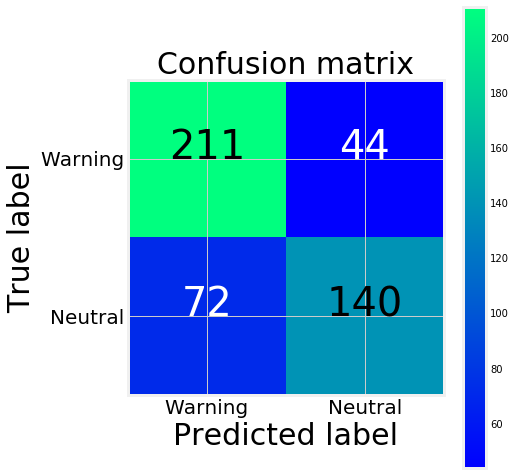

[[211  44]
 [ 72 140]]


In [103]:
cm = confusion_matrix(y_test, y_preds_tfidf)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['Warning','Neutral'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

[[211  44]
 [ 72 140]]


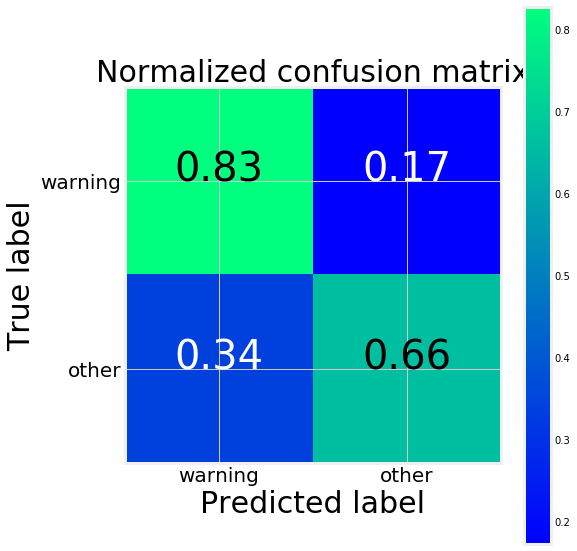

In [104]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_tfidf)
np.set_printoptions(precision=2)
print(cnf_matrix)

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['warning','other'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

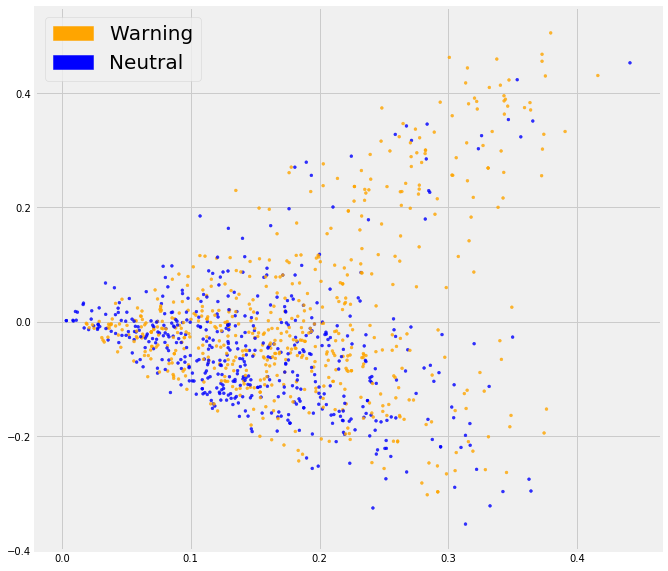

In [105]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
from matplotlib import patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Warning')
            green_patch = mpatches.Patch(color='blue', label='Neutral')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [106]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [107]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Warnings', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Neutral', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [108]:
sgdc_binary = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
sgdc_binary.fit(X_train_tfidf, y_train)



SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [109]:
Y_pp = pd.DataFrame(sgdc_binary.predict_proba(X_test_tfidf), columns=['warning_pp','neutral_pp'])
Y_pp.head(10)

,warning_pp,neutral_pp
0,0.403823,0.596177
1,0.448051,0.551949
2,0.936005,0.063995
3,0.472479,0.527521
4,0.388945,0.611055
5,0.676644,0.323356
6,0.871893,0.128107
7,0.816239,0.183761
8,0.287541,0.712459
9,0.216593,0.783407


In [110]:
def threshold(th):
    Y_pp['outcome'] = [1 if x >= th else 0 for x in Y_pp.neutral_pp.values]
    fn = np.sum((y_test == 0) & (Y_pp.outcome == 1))
    return fn

In [111]:
for i in np.linspace(0.15,0.85,10):
    print(i,':',threshold(i))

0.15 : 41
0.22777777777777777 : 34
0.3055555555555556 : 29
0.3833333333333333 : 25
0.46111111111111114 : 21
0.5388888888888889 : 17
0.6166666666666667 : 16
0.6944444444444445 : 13
0.7722222222222223 : 12
0.85 : 8


In [112]:
from sklearn.metrics import roc_curve, auc

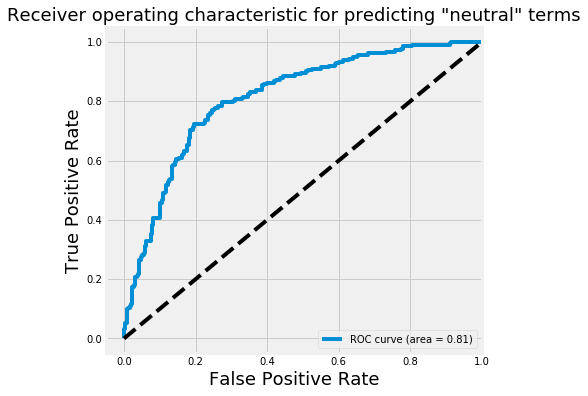

In [113]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, Y_pp.neutral_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (female)
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for predicting "neutral" terms', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [114]:
importance_tfidf = get_most_important_features(tfidf, sgdc_binary, 10)

In [115]:
importance_tfidf

{0: {'tops': [(3.3869382138089374, 'choice'),
   (3.498571149719925, 'link'),
   (3.5335912260499693, 'personal'),
   (3.6328717627267455, 'll'),
   (3.787412887206135, 'text'),
   (3.827866175959078, 'opt'),
   (4.071894685740653, 'copyright'),
   (4.115662952363794, 'doe'),
   (4.216744936843721, 'identifying'),
   (4.787210654089864, 'ownership')],
  'bottom': [(-3.0260665559813718, 'company'),
   (-3.0968937656172684, 'described'),
   (-3.1074519334107924, 'virtual'),
   (-3.127786407737834, 'disclose'),
   (-3.239854564255016, 'service'),
   (-3.3405179245414205, 'reason'),
   (-3.392368178247317, 'reserve'),
   (-3.53566322401147, 'damage'),
   (-3.639069320691309, 'activity'),
   (-4.184853173464171, 'advertiser')]}}

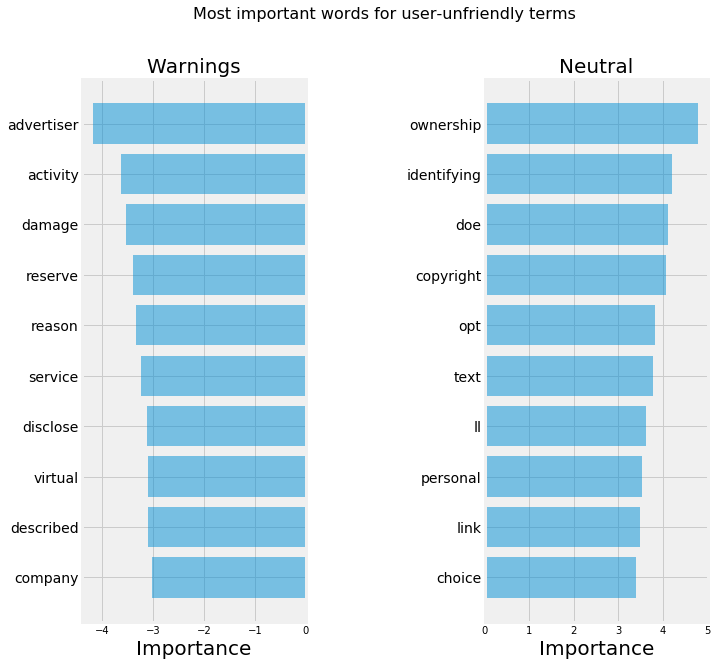

In [116]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for user-unfriendly terms")

In [117]:
topic_class= pd.DataFrame(conf_dict1)
topic_class = topic_class[topic_class.true_topic != topic_class.pred_topic]

In [118]:
warn_class= pd.DataFrame(conf_dict2)
warn_class = warn_class[warn_class.true_class != warn_class.pred_class]

In [119]:
double_wrong = pd.merge(topic_class, warn_class, left_index=True, right_index=True)

In [120]:
quotes = df[['quoteText']]

In [121]:
double_wrong_quotes = pd.merge(double_wrong, quotes, left_index=True, right_index=True)

In [122]:
double_wrong_quotes

,true_topic,pred_topic,true_class,pred_class,quoteText
526,Governance,Waiving your right,1,0,No recovery may be sought or received for dama...
1425,Personal Data,Right to leave the service,0,1,"If you have created a user account, you bear ..."
505,Personal Data,Logs,1,0,"IP Logging:</strong> By default, ProtonMail do..."
810,Governance,Scope of the copyright licence,1,0,"Unless otherwise specified, the Services are f..."
10,Suspension and Censorship,Governance,1,0,"""Should users do not lower the bandwidth despi..."
905,Anonymity and Tracking,Cookies,0,1,COOKIES: Cooies help us in many ways to make y...
1000,Scope of the copyright licence,Personal Data,0,1,The core data of the database is licensed unde...
16,Changes to Terms,Governance,1,0,we believe that community input is essential f...
323,Changes to Terms,Personal Data,0,1,> For revisions to this Privacy Policy that ma...
1657,Guarantee,Personal Data,0,1,We do not guarantee that any of the informatio...


In [123]:
for i in double_wrong_quotes.index:
    print(double_wrong_quotes.quoteText[i])
    print()
    print("Originally classified as: ", double_wrong_quotes.true_topic[i])
    print("Predicted as: ", double_wrong_quotes.pred_topic[i])
    print("Predicted neutral?: ", double_wrong_quotes.pred_class[i])
    print()
    print()

No recovery may be sought or received for damages other than out-of-pocket expenses, except that the prevailing party will be entitled to costs and attorneys’ fees.
In the event of any controversy or dispute between Apple and you arising out of or in connection with your use of the Site, the parties shall attempt, promptly and in good faith, to resolve any such dispute.
If we are unable to resolve any such dispute within a reasonable time (not to exceed thirty (30) days), then either party may submit such controversy or dispute to mediation.
If the dispute cannot be resolved through mediation, then the parties shall be free to pursue any right or remedy available to them under applicable law.</p>

Originally classified as:  Governance
Predicted as:  Waiving your right
Predicted neutral?:  0


 If you have created a user account, you bear the sole responsibility for information that you fill in when registering or when modifying your account.

Originally classified as:  Personal Data
Pr

## Evaluation & next steps

The score of 0.67 compared to 0.11 baseline for classifying by topic is relatively positively, considering there are 19 topics. The good/bad classification of 0.75 is also promising, although less impressive compared to the baseline of 0.54 for the binary prediction.

There are two areas for next steps:
    1. Improving the model
    2. Building a proof of concept for a classification tool

While there are conceivably other options to try in terms of NLP models (Doc2Vec in particular), the overall performance is unlikely to be much improved without a better dataset. For example - more data - but also better-classified data. It is clear from some of the misclassifications that the model understandably chooses some topics whereas a human has chosen another. Because of the subjective nature of classifying into topic, it is difficult to say in every case that the human classifier is correct and the model is wrong. The subject could benefit from a review of the classification and perhaps a new framework for topics/meaning, but this would be a much larger undertaking.

However, this does not invalidate the exercise, and my further plan is to create a front-end proof of concept using Flask, with the following workflow:
* accept input from a URL of a Terms of Service / Privacy Policy document
* scrape the page and split the document by logical separator (eg. paragraph break) into separate snippets/observations
* use the warning/neutral classifer to identify which paragraphs are of potential interest to a user
* predict the topic of those selected paragraphs and display them to the user in a categorised output
* potentially - explore using GenSim summariser to present a summarized version of the paragraph as well

This would present a simple tool for important/concerning terms to be highlighted and displayed without the user having to read the document in full. The model could then be further enhanced with improvements to the training set.